In [4]:
import numpy as np
import pandas as pd
import seaborn  as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import plot_tree
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import altair as alt


In [7]:
from google.colab import files
uploaded = files.upload ()

Saving prices.csv to prices.csv


In [8]:
df = pd.read_csv('prices.csv')
df.head()


,Date,Codigo empresa,Close
0,2024-05-08,MMM,96.349998
1,2024-05-09,MMM,97.330002
2,2024-05-10,MMM,98.930000
3,2024-05-13,MMM,99.629997
4,2024-05-14,MMM,100.080002


In [9]:
print(df.dtypes)


Date               object
Codigo empresa     object
Close             float64
dtype: object


In [10]:
df['Date'] = pd.to_datetime(df['Date'])
print(df.dtypes)

Date              datetime64[ns]
Codigo empresa            object
Close                    float64
dtype: object


In [11]:
df_sorted = df.sort_values(by=['Codigo empresa','Date'])
print(df_sorted.head())



          Date Codigo empresa       Close
620 2024-05-08              A  142.800003
621 2024-05-09              A  145.139999
622 2024-05-10              A  149.759995
623 2024-05-13              A  147.759995
624 2024-05-14              A  151.279999


In [12]:
df['return'] = df.groupby('Codigo empresa')['Close'].pct_change()*100
print(df.head())


        Date Codigo empresa       Close    return
0 2024-05-08            MMM   96.349998       NaN
1 2024-05-09            MMM   97.330002  1.017129
2 2024-05-10            MMM   98.930000  1.643890
3 2024-05-13            MMM   99.629997  0.707568
4 2024-05-14            MMM  100.080002  0.451676


In [13]:
df['return'] = df['return'].fillna(0)
print(df.head())

        Date Codigo empresa       Close    return
0 2024-05-08            MMM   96.349998  0.000000
1 2024-05-09            MMM   97.330002  1.017129
2 2024-05-10            MMM   98.930000  1.643890
3 2024-05-13            MMM   99.629997  0.707568
4 2024-05-14            MMM  100.080002  0.451676


In [14]:
print(df[df['Codigo empresa']=='LUMN'])

            Date Codigo empresa  Close     return
17546 2024-05-08           LUMN   1.28   0.000000
17547 2024-05-09           LUMN   1.34   4.687505
17548 2024-05-10           LUMN   1.31  -2.238813
17549 2024-05-13           LUMN   1.25  -4.580149
17550 2024-05-14           LUMN   1.33   6.400003
...          ...            ...    ...        ...
17603 2024-07-31           LUMN   3.15  17.977528
17604 2024-08-01           LUMN   3.32   5.396820
17605 2024-08-02           LUMN   3.07  -7.530121
17606 2024-08-05           LUMN   2.59 -15.635180
17607 2024-08-06           LUMN   5.00  93.050199

[62 rows x 4 columns]


In [15]:
stats_df = df.groupby('Codigo empresa')['return'].agg(['std', 'max', 'min', 'mean']).reset_index()

stats_df['range'] = stats_df['max'] - stats_df['min']

stats_df['mean_absolute'] = stats_df['mean'].abs()

stats_df.rename(columns={'std': 'std_return', 'max': 'max_return', 'min': 'min_return', 'mean': 'mean_return'}, inplace=True)

stats_df.drop(columns=['max_return','min_return','mean_return'], inplace = True)

print(stats_df)


    Codigo empresa  std_return      range  mean_absolute
0                A    1.950142  13.519227       0.056413
1              AAL    2.564001  18.809769       0.669493
2              AAP    2.709984  18.142082       0.366213
3             AAPL    1.714124  12.081612       0.217400
4              ABT    1.374671   8.377845       0.077908
..             ...         ...        ...            ...
484            YUM    1.117568   5.252286       0.004840
485            ZBH    1.149233   6.574299       0.151394
486           ZBRA    1.657363   9.808292       0.003560
487           ZION    2.148409  12.066949       0.093096
488            ZTS    1.466898   9.184086       0.198487

[489 rows x 4 columns]


In [16]:
#Normalizacion

metrics = stats_df[['std_return', 'range', 'mean_absolute']]

scaler = StandardScaler()

scaled_metrics = scaler.fit_transform(metrics)

scaled_df = pd.DataFrame(scaled_metrics, columns=['std_return', 'range', 'mean_absolute'])

print(scaled_df.head())

   std_return     range  mean_absolute
0    0.161296  0.351781      -0.544996
1    0.833650  1.062813       2.894813
2    0.993543  0.973078       1.193200
3   -0.097211  0.158570       0.358250
4   -0.469011 -0.339204      -0.424394


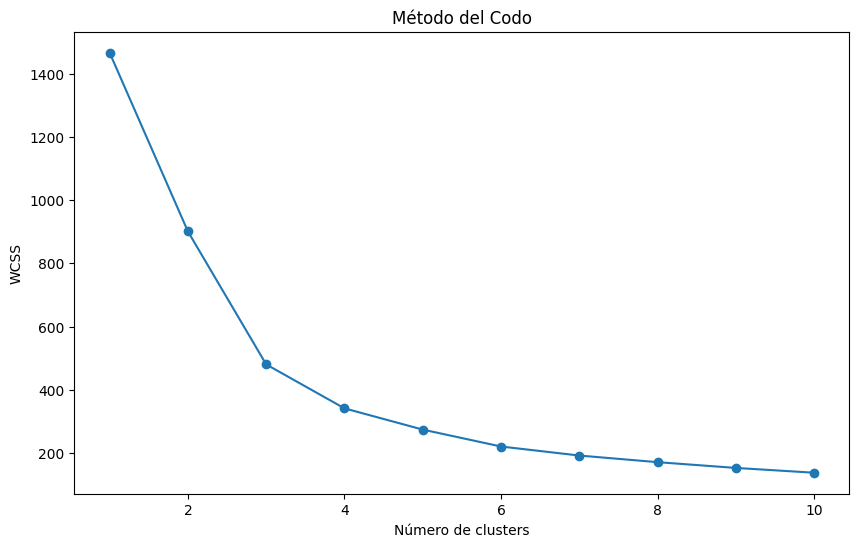

In [17]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()


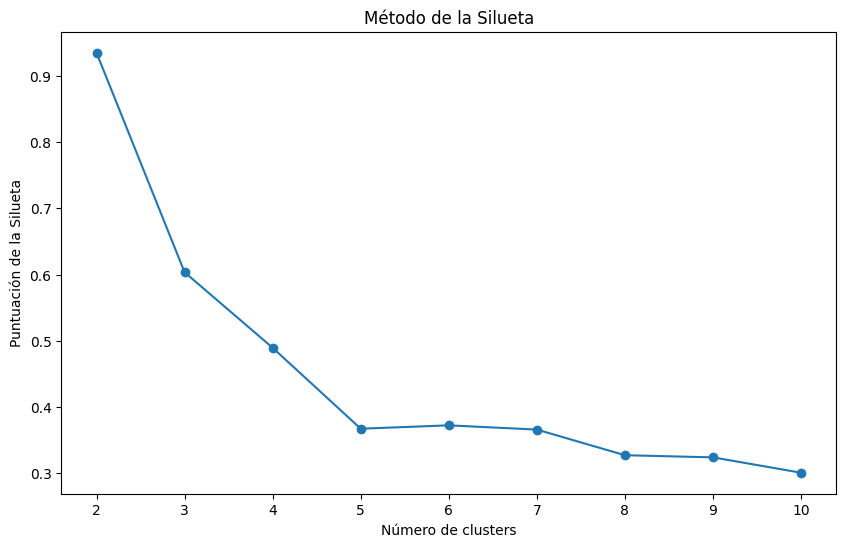

In [18]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_df)
    silhouette_avg = silhouette_score(scaled_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Método de la Silueta')
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación de la Silueta')
plt.show()

In [19]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
stats_df['cluster'] = kmeans.fit_predict(scaled_df)

print(stats_df.head())

  Codigo empresa  std_return      range  mean_absolute  cluster
0              A    1.950142  13.519227       0.056413        0
1            AAL    2.564001  18.809769       0.669493        2
2            AAP    2.709984  18.142082       0.366213        2
3           AAPL    1.714124  12.081612       0.217400        0
4            ABT    1.374671   8.377845       0.077908        0


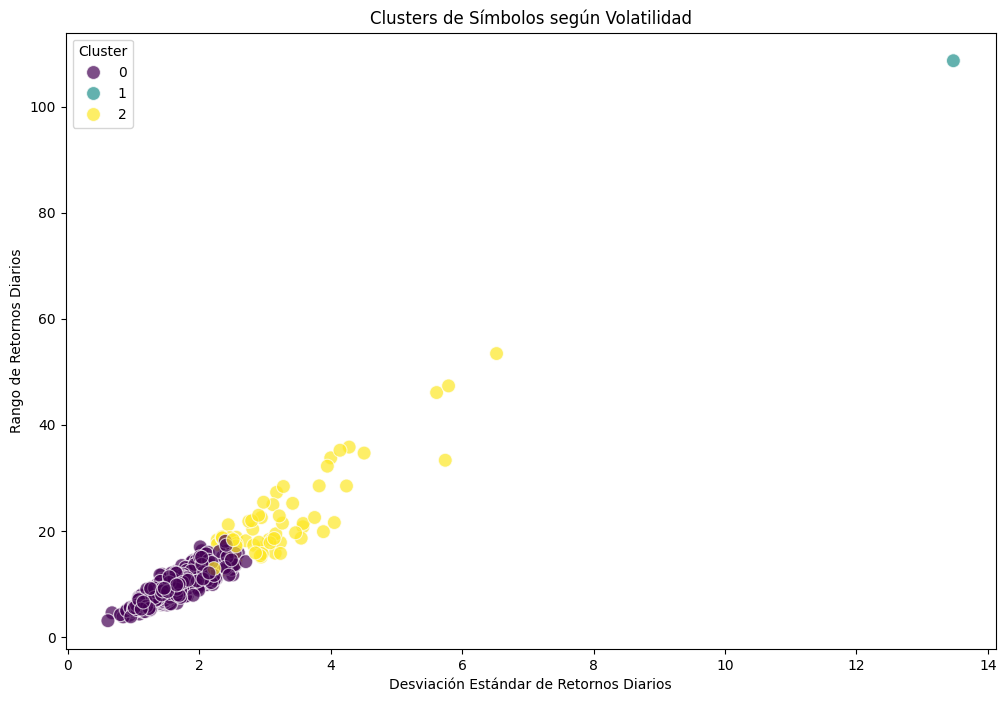

In [20]:
# Graficar los clusters usando dos dimensiones para la visualización
plt.figure(figsize=(12, 8))
sns.scatterplot(x='std_return', y='range', hue='cluster', palette='viridis', data=stats_df, s=100, alpha=0.7)
plt.title('Clusters de Símbolos según Volatilidad')
plt.xlabel('Desviación Estándar de Retornos Diarios')
plt.ylabel('Rango de Retornos Diarios')
plt.legend(title='Cluster')
plt.show()

#Conclusiones
1. Para calcular el número óptimo de clusters dado que se esta tratando con métricas estadísticas (desviación estándar, diferencia entre máximos y mínimos, etc.) derivadas de datos financieros, se hizo uso de los metodos del codo y de la silueta, el primera para una estimacion incial y el segundo para una evaluacion mas detallada de la calidad del clustering.

2. Observando el gráfico de los metodos empleados (silueta y codo), se puede ver que la puntuación de la silueta es máxima cuando K=3. Esto sugiere que, según este método, el número óptimo de clusters para tus datos es 3.

3. El gráfico muestra que las empresas pueden clasificarse en diferentes grupos según su nivel de volatilidad. Esta información es valiosa para los inversores, los gestores de riesgo y los analistas financieros.
Cluster de Baja Volatilidad: Las empresas en este cluster podrían ser grandes empresas establecidas en industrias maduras, estas empresas suelen tener una base de clientes estable y operaciones recurrentes, lo que contribuye a su menor volatilidad.
Cluster de Alta Volatilidad: Las empresas en este cluster suelen estar expuestas a mayores incertidumbres y cambios en el mercado, lo que se traduce en una mayor volatilidad.
Cluster Intermedio: Las empresas en este cluster podrían ser una mezcla de empresas de diferentes tamaños y sectores, que no encajan perfectamente en los otros dos clusters.

4.  El análisis de clusters de empresas según su volatilidad puede ser una herramienta invaluable para tomar decisiones financieras ya que pueden identificar segmentos de activos financieros que comparten características similares de volatilidad, por ejemplo los clusters que muestran alta volatilidad pueden indicar altos niveles de riesgo.
